# ASTR 596: FDS Homework 7: Selection Effects as Hierarchical Models



## <font color='red'> When you first look at the size of the notebook, it'll be overwhelming. There is a lot of text largely to help explain things step by step. It's just really broken up into many small steps. Answers for Q1-7 are 1--2 lines each. and Q8 is 10. The PGM will take longer if you use `daft` than anything else.
</font>


#### So far, we've been making inferences from sample assuming that the sample we're working with is representative of the underlying population.

#### This is a fantastically bad assumption, because it's almost always wrong. 

#### Every astronomical dataset we've used in this class exhibits *selection effects* - you saw fewer Cepheids in more distant galaxy, you saw fewer stars in SDSS in regions with high extinction, you miss variable stars with periods around 1 day because you sample the sky with the same timescale imposed by the Earth's rotation, you don't see meteors like Chelyabinsk coming in from the direction of the Sun because the background is too high to detect such faint sources...

<img src="../../homework/08/selection_effect.png">

#### If you imagine a forward model for the data, then there's one extra step now that impacts what you get in your sample, and so the inverse problem - learning about the population from the sample - is potentially biased by the failure to account for selection effects.

#### Since selection effects enter via detection criteria, we have to incorporate these into the model.

#### You're going to build a forward model for a survey incorporating selection effects.

<hr>

We'll simulate survey observations based on a simplified model for photon-counting aperture photometry.

If our model telescope has a collecting area $A$ and integrates for a time $T$, the total exposure $\epsilon = A\cdot T$ toward a targeted source. 

The expected number of source photons detected from a source with photon number flux $F$ is thus $\epsilon \cdot F$.

Of course backgrounds and instrumental contributions to the detected photons. Sky backgrounds and integrating instrumental backgrounds (such as dark current for a CCD) can be modeled by adding a background rate, $B$, to the flux.  We'll also consider additive contamination with a fixed expected number of counts, $C$ (such as from effects like readout or amplifier noise).  

The total expected number of counts from a source is:
\begin{align}
\mu(F) & = \epsilon F + \epsilon B + C \\
 & = \epsilon F + \nu
\end{align}

with $\nu \equiv \epsilon B + C$ denoting the expected number of non-source photons. We'll assume that all the exposures are the same.

In this setup, the data from the observation of a source comprise a single integer, the observed number of counts in aperture, $n$ (we'll use $n_i$ when we consider multiple sources, with $i$ being the source index).

<hr>

<font color='blue'>

#### Q1. To *simulate* observations, we need to specify a *sampling distribution* telling us how to generate data when the *source* properties are specified. We've encountered this distribution multiple times already (remember you don't get a non-integer number of photons). Write down an expression for the sampling distribution for the number of photons $n$ given the source flux $F$


##### Your expression here

</font>

Normally the The Poisson distribution is appropriate for modeling the number of times an event occurs in an interval of time (or space). So it is great to use here when modeling a detector.

Typically the number of times an event occurs in an interval (an integer number) is written as $k$, the observed number of counts in aperture. Also, what is normally $\lambda$, the average number of events per interval, is our source count normalization, or the expectation value of the flux $\epsilon F$. Thus, we have

$$P(n|F) = \frac{(\epsilon F)^k e^{- \epsilon F}}{k!} $$

And we don't care about $\nu$ here yet b/c that's nonsource, while here we only care about source photons.

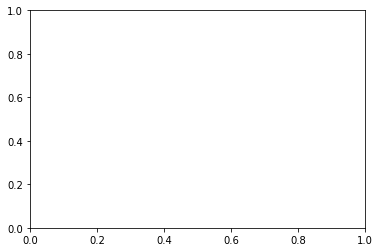

In [1]:
# and implement the distribution in code here
from scipy.stats import poisson
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

#initial setup
eps = .8
Flux = 150

#one source, it would look like something like this
n = poisson.rvs(eps*Flux, size=1)

In [2]:
print(n)

[142]


<hr>
<font color='blue'>
    
#### Q2. Once we have simulated data, we need the *likelihood function* $\ell(F)$ in order to estimate the source flux $F$ given the detected photons $n$ except now we have to take into account the noise model. Write down an expression for the likelihood function for the source Flux, given the number of photons $n$.

##### Your expression here
    
</font>

Remember that the likelihood is *not normalized over flux*  - it isn't meaningful to integrate it over $F$ without multiplication by a prior (such as a candidate population distribution for $F$).  

Normally we would have via Bayes Theorem

$$ P(n|F) = \frac{P(F|n) P(n)}{P(F)} $$

where $P(n|F)$ was our posterior and $P(F|n)$ was our likelihood. However from the below hint, this likelihood isn't normalized over flux b/c it isn't meaningful to intergrate it over $F$ w/o multiplying by a prior P(n). And so we have

$$ P(n|F) \approx P(F|n, \nu) $$

with the only difference being we add in a noise model, which we assume to also be a Poisson distribution. 

$$ \mathscr{L} = \prod_i^N \frac{(\epsilon F_i + \nu)^k e^{- (\epsilon F_i + \nu)}}{k!} =  \prod_i^N \frac{(n + \nu)^k e^{- (n + \nu)}}{k!}$$

$$ log \mathscr{L} = \sum_i^N \left(-(\epsilon F_i + \nu) - log(k!) + k \log(\epsilon F_i + \nu) \right) = \sum_i^N \left(-(n + \nu) - log(k!) + k \log(n + \nu) \right) $$

where $N$ is total number of sources $i$, and $n_i = \epsilon F_i$.

In [3]:
import numpy as np

k=n
nu=2

def neg_log_L(n):
    if (n < 0).any():
        return -99999
    
    ell = -(n+nu) - np.log(float(np.math.factorial(k))) + k*np.log(n+nu)
    #ell = -((n-nu)/eps) - np.log(float(np.math.factorial(k))) + k*np.log((n-nu)/eps)
    return -ell

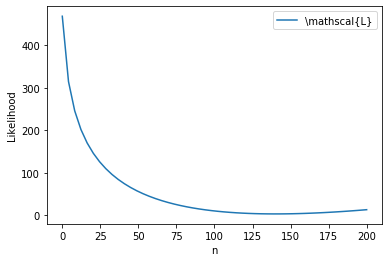

In [4]:
n2 = np.linspace(0,200)
plt.plot(np.linspace(0,200), neg_log_L(n2), label=r'\mathscal{L}')
plt.legend()
plt.xlabel('n');
plt.ylabel('Likelihood');

<hr> 
<font color='blue'>

#### Q3. The $n$-dependent MLE estimate of the source flux, $\hat{F}(n)$, can be found by setting $\ell'(\hat{F}) = 0$. Write down the maximum likelihood estimate of the flux.

##### Your expression here
    
</font>

we take first derivative w.r.t. k, and we find for our MLE eq:

$$ -N + \frac{\sum_i^N k}{\epsilon F_i + \nu} = 0. $$
$$ N = \frac{\sum_i^N k}{\epsilon F_i + \nu} $$

And if the total source is 1 (N=1), then

$$ k = \epsilon F_i + \nu. $$

And b/c $n$ is really $k$
$$ \hat{F}(n) = \frac{(n-\nu)}{\epsilon} $$

Our estimate of $F$ is

In [5]:
from scipy.optimize import minimize

r = minimize(neg_log_L, n)

Flux_MLE = (r.x - nu)/eps
Flux_analytic = (n - nu)/eps
print(Flux_MLE, Flux_analytic)

[172.49956452] [175.]


In [6]:
def f_hat(n, nu, Flux): return (n - nu)/Flux
f_hat(poisson.rvs(Flux_MLE*100), nu, Flux_MLE)/100

array([0.99142279])

Wahoo! My flux estimates from both minimzing the log likelihood and my analytic result are SUPER close, and so this gives me confidence!

At first I ddin't understand what this comment meant:

In [7]:
#you can sanity check your work here 
#by interpreting this expression and seeing if it makes sense

but I do now. :)

<hr>
<font color='blue'>

#### Q4. The $n$-dependent standard deviation of the Gaussian can be found by computing a second derivative of the likelihood and matching it to the second derivative of the Gaussian.

##### Your expression here
    
</font>

We take another derivative of this

$$ -N + \frac{\sum_i^N n_i}{\epsilon F_i + \nu} = 0. $$

w.r.t. $\epsilon F_i$ and find

$$ \frac{-1}{(\epsilon F +\nu)^2} \sum_i^N n_i $$

And thus, at N=1:

$$ \frac{-n}{(\epsilon F +\nu)^2}. $$

This is the observed Fisher-information. And so, the variance goes as $\sim n$ and the standard deviation (error) goes as $\sim \sqrt{{n}}$

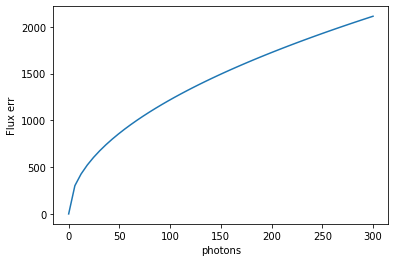

In [79]:
t2 = np.linspace(0,300) #say this is photons we can see how it scales
err_F_t2 = ((eps*Flux) + nu)*np.sqrt(t2)
plt.plot(t2, err_F_t2)
plt.xlabel('photons');
plt.ylabel('Flux err');

this is indeed what we expected/

In [9]:
# and implement the estimate for the uncertaintity in the source flux F here

# you can sanity check your work here by looking at how this expression scales with the number of detected photons n

<hr>

<img src="../../homework/08/selection_effect_so_far.png">

OK, if we're good up to here, we've specified how to go from observables ($F$) to measurements ($n$) i.e. we know given a source with flux, $F$ we use the sampling distribution to get an estimate of the number of photons $n$ 

We now have to specify a **population distribution** for sources - what's the distribution of $F$ itself across sources.

We'll use a version of a power-law distribution.

Let $g(F; \theta)$ denote the flux distribution probability density function $PDF$, with parameters $\theta$ (that we will sometimes suppress for notational brevity).  


It's annoying to have to think about behavior in terms of the actual flux in ergs/cm^2/sec so instead let us convert to a dimensionless flux. If we choose a *fiducial flux*, $F_0$ - maybe a physically interesting scale (e.g., a solar luminosity at 10 pc), or simply a convenient unit (e.g., $10^{-7}$ photons/cm$^2$/s), then we can switch to log space using:

$$
x = \log\left(\frac{F}{F_0}\right), \qquad\qquad
y = \log\left(\frac{g(F)}{g(F_0)}\right).
$$

A power law is a straight line in $(x,y)$ space; its slope is the *power law index* (sometimes the negative slope is called the index).  

That is, if

$$
g(F) = C\left(\frac{F}{F_0}\right)^\alpha,
$$

with $C$ a normalization constant, then 

$$
\frac{dy}{dx} = \alpha.
$$


Let's generalize this a bit, seeking to make the power law index vary with flux.  Let's pick $F_0$ to be the flux at which the slope is $\alpha$, and let the slope change linearly away from there. This leads to
$$
\frac{dy}{dx} = \alpha + \beta x.
$$

This corresponds to power law behavior with index $\alpha$ at $\xi$, but with the index linearly "rolling" with respect to log-flux.


What does such a choice for the transformed log flux $x$ imply for the real flux $F$ distribution? First note that although $g(F)$ is a PDF for $F$, it's not the case that $y(x)$ is a PDF for $x$.  The nonlinear change of variables from $F$ to $x$ means that the PDF for $x$, $h(x)$, must be computed using a Jacobian:

\begin{align}
h(x) 
  &= g(F(x))\left|\frac{dF}{dx}\right| \\
  &= g[F_0 e^x]\, F_0 e^x.
\end{align}

Conversely, if we specify the PDF for the log-flux, we can compute $g(F)$ via
\begin{align}
g(F) 
  &= h(x(F))\left|\frac{dx}{dF}\right| \\
  &= \frac{1}{F} h[\log(F/F_0)].
\end{align}
(Check the dimensions again!)

If $h(x)$ is a normal distribution (for $x$, the log-flux), with mean $\mu$ and standard deviation $\sigma$ (both dimensionless). We then have
$$
h(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(x - \mu)^2}{2\sigma^2}\right].
$$


This corresponds to a $g(F)$ given by the Jacobian rule above:
$$
g(F) = \frac{1}{F}\cdot\frac{1}{\sigma\sqrt{2\pi}} \exp\left[-\frac{(\log(F/F_0) - \mu)^2}{2\sigma^2}\right].
$$
This is a *log-normal distribution* for the flux.


Now compute its slope in $(x,y)$ log space.  The result is
$$
\frac{dy}{dx} = \left(\frac{\mu}{\sigma^2} - 1\right) - \frac{x}{\sigma^2}.
$$

Comparing with our linearly-rolling law, above, we see that a log-normal distribution corresponds to a rolling power law with index $\alpha = \mu/\sigma^2 -1$ at $F=F_0$, and with rate of change of slope $\beta = -1/\sigma^2$.  Note that $\beta$ must be negative.

So a log-normal flux distribution will look like a power law with index $\alpha = \mu/\sigma^2-1$ if $\beta$ is small (i.e., $\sigma$ is large). Estimating $\beta$ measures departure from pure power law behavior.


## Phew.

<font color='blue'>
    
#### Q5. Given alpha and beta, write code that implements a log-normal flux PDF

#### Scipy of course has this, **but see the note here bout SciPy's funky scale param**:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
  
##### Plot the PDF as a function of the dimensionless flux $F/F_0$ with a log-log scale
    
</font>

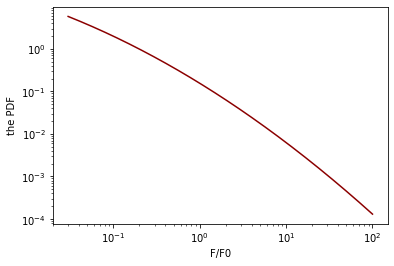

In [81]:
alpha, beta = -1.5, -0.25  # fiducial index, roll rate
f_vals = np.logspace(np.log10(0.03), np.log10(100), 250)

sig = np.sqrt(-1/beta)
mu = -(alpha+1)/beta
# implement the log-normal population PDF in terms of the dimensionless flux F/F_0
F_F0 = np.linspace(0.03, 100, 250)
def g(F):
    log_norm_pdf = (1/F) * 1 / (sig*np.sqrt(2*np.pi) ) * np.exp(-((np.log(F)- mu)**2) / (2*sig)**2  )
    return log_norm_pdf 

# plot the population PDF in log-log scales
plt.plot(f_vals, g(f_vals), color='darkred')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('F/F0');
plt.ylabel('the PDF');

<hr> 

Finally, the presence of backgrounds means that photons will be counted in an aperture even in the absence of a source.  

To guard against false detections, we introduce a detection threshold, $n_{\rm threshold}$, requiring that $n > n_{\rm th}$ for a candidate source to enter the survey catalog.  For simplicity, we'll choose $n_{\rm threshold}$ large enough that the probability for a false detection is negligible, so the catalog is "pure" with high probability.

The cost of purity is missing sources - we reject dim sources that happen to produce counts below threshold - our catalog is **incomplete**.

To account for this, we need the *detection efficiency*, $\eta(F)$, the probability for detecting a source of flux $F$.  This is just the probability of getting $n > n_{\rm th}$ when $F$ is given:

\begin{align}
\eta(F) 
  &= p(n > n_{\rm th}|F) \\
  &= \sum_{i=n_{\rm th}+1}^\infty p(n|F)
\end{align}

<font color='blue'>
    
#### Q6. To write this as an expression for the detection efficiency $\eta(F)$, consider the [Incomplete gamma function - Wikipedia](https://en.wikipedia.org/wiki/Incomplete_gamma_function). 

#### The combination $P(s,x) \equiv \gamma(s,x)/\Gamma(s)$ (with $\Gamma(s)$ the gamma function) is called the regularized lower incomplete gamma function; SciPy provides this as `scipy.special.gammainc(s,x)`.  When $s$ is an integer, $\Gamma(s) = (s-1)!$

##### Your expression here for the detection efficiency here
    
</font>

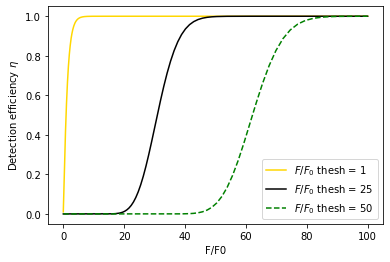

In [82]:
# and implement the detection efficiency here
from scipy.special import gammainc

def det_efficiency(n_th, F):
    F_th = n_th / eps
    cutoff = gammainc(F_th, F)
    return cutoff

eta_1 = det_efficiency(1, f_vals)
eta_25 = det_efficiency(25, f_vals)
eta_50 = det_efficiency(50, f_vals)

# plot the detection efficiency as a function of the dimensionless flux in linear-linear axes
plt.plot(f_vals, eta_1, color='gold', label='$F/F_0$ thesh = 1')
plt.plot(f_vals, eta_25, color='k', label='$F/F_0$ thesh = 25')
plt.plot(f_vals, eta_50, 'g--', label='$F/F_0$ thesh = 50')
plt.legend()
plt.xlabel('F/F0');
plt.ylabel(r'Detection efficiency $\eta$');

# Parameter choices

For our simulation we must specify the survey parameters governing measurement and detection, and a choice of parameters for the underlying "true" flux distribution.

First let's specify the detection threshold.  

A convenient and common specification is to choose $n_{\rm th}$ so that $\hat{F}(n_{\rm th})$ is some fixed multiple, $k$, of the uncertainty, $\sigma_F(n_{\rm th})$ (i.e., we require detections to be above "$k$ sigma").  This corresponds to solving
$$
\hat{F}(n_{\rm th}) = k\, \sigma_F(n_{\rm th})
$$
for $n_{\rm th}$.  

This gives an equation involving $n_{\rm th}$ and $\sqrt{n_{\rm th}}$, i.e., a quadratic equation for $\sqrt{n_{\rm th}}$.  The solution is
$$
n_{\rm th} = k^2\, \left(\frac{1 + \sqrt{1 + 4\nu/k^2}}{2}\right)^2.
$$
Note that if the expected background contribution $\nu=0$, we have $n_{\rm th} = k^2$, a result we would have guessed from the root-$n$ rule.

#### As a starting point, let's use a 4-$\sigma$ detection criterion, with $\nu = 9.373$, for which
$$
\large
n_{\rm th} = 2 k^2 = 32.
$$

Now we must specify the effective area and integration time, or equivalently, the exposure, $\epsilon$.  Since only the product, $\epsilon F$, enters the calculations, for any choice of flux scale, we can find an exposure that will produce any desired photon count expectation value.  

#### We'll choose the exposure so that the expected counts will equal $n_{\rm th}$ for a flux $F = 0.1 F_0$; that is, we set
$$
\large 
0.1 \epsilon F_0 + \nu = n_{\rm th},
$$

which gives 

#### $$\epsilon = 320/F_0$$  

We can set $F_0$ to a specific value; alternatively we can work in terms of a dimensionless flux, $f = F/F_0$. 

#### For the population model, let's set the index at $F_0$ to have rolled off of the canonical homogenous population value, $\alpha = -5/2$, by one, i.e., $\alpha = -1.5$.  As a starting point we'll consider $\beta = -0.25$.  When the flux reaches $\approx 50\times F_0$, the log-slope reaches the $-5/2$ value.


#### THAT'S EVERYTHING SPECIFIED IN THE FIGURE

<hr> 

<font color='blue'>

#### Q7. OK, so now apply the detection efficiency to the population distribution, and show the original distribution vs the detected population that is subject to selection effects (aka "thinned"). As you've hopefully realized from the Q5., it'll pay to work in log-log axes. 
    
</font>

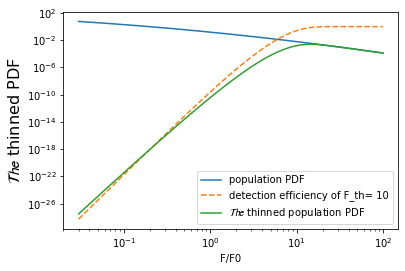

In [83]:
# plot the thinned population - i.e. the population distribution subject to selection effects - log-log again



eta_10 = det_efficiency(10, f_vals)
thin_pop = g(f_vals) * eta_10


plt.plot(f_vals, g(f_vals), label='population PDF')
plt.plot(f_vals, eta_10, ls='--', label='detection efficiency of F_th= 10')
plt.plot(f_vals, thin_pop, label='$\mathcal{The}$ thinned population PDF')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('F/F0');
plt.ylabel('$\mathcal{The}$ thinned PDF', fontsize='16');

<font color='blue'>
    
#### Q8. Monte-Carlo time! 

#### Simulate a catalog with 10,000 **detections**. Because of selection effects there'd better be more underlying sources than the ones you detected. 

* Draw the latent (true) fluxes from the **population distribution** - keep a track of these true fluxes
* The total expected number of photons $\mu(F) = \epsilon F + \nu$ again - keep a track of these true counts
* Using your answer for Q1 i.e. the **sampling distribution** to simulate a signal
* Using your answer for Q3 i.e. the MLE estimate of the flux (which depends on what you did in Q2), estimate the flux of your signal - keep a track of these estimated fluxes
* Just because a process generated a signal does not mean that you detected that signal. Apply the detection threshold n_threshold to the signals you simulated
* Keep generating until you 10,000 detections

Finally, plot the true vs estimated fluxes for all signals you simulated in red, and the signals you actually detected in blue.

Histogram the estimated flux for all signals and detected signals and compare to your answer for Q7. You'll need to use log-log again.

</font>

Flux diff is (9722,)
Count diff is (6890,)


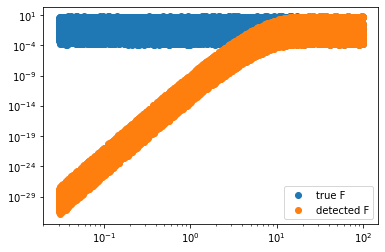

In [69]:
f_vals_10k = np.logspace(np.log10(0.03), np.log10(100), 10000)



true_flux = np.random.choice(g(f_vals), size=10000)
eta_cut = det_efficiency(10, f_vals_10k)
detected_true_flux = true_flux * eta_cut
flux_diff = true_flux - detected_true_flux
print('Flux diff is', np.shape(np.unique(detected_true_flux)))

new_nu = poisson.rvs(0, size=10000)
all_cts = (true_flux*eps) + new_nu
detected_cts = (detected_true_flux*eps) + new_nu
cts_diff = all_cts - detected_cts
print('Count diff is', np.shape(np.unique(cts_diff)))

est_flux = f_hat(n, nu, Flux_MLE)/100
    
plt.plot(f_vals_10k, true_flux, 'o', lw='.7', label='true F')
#plt.plot(f_vals_10k, eta_cut, 'o', lw='.7')
plt.plot(f_vals_10k, detected_true_flux, 'o', lw='.7', label='detected F')
plt.yscale('log')
plt.xscale('log')
plt.legend()



# These will hold the data, i.e., counts.
#all_cts, detected_cts = [], []

# Keep track of true fluxes.
#true_flux, detected_true_flux = [], []

# These will hold dimensionless flux estimates.
#est_flux, detected_est_flux = [], []


# YOUR MONTECARLO CODE HERE - LOOK AT HW3 IF YOU NEED A REFRESHER 

# PLOT true vs estimated flux for all and only detected signals here - log-log

# Histogram estimated fluxes for all and detected signals and compare to Q7.

In [71]:
from scipy.stats import lognorm
# These will hold the data, i.e., counts.
all_cts, detected_cts = [], []

# Keep track of true fluxes.
true_flux, detected_true_flux = [], []

# These will hold dimensionless flux estimates.
est_flux, detected_est_flux = [], []

# YOUR MONTECARLO CODE HERE - LOOK AT HW3 IF YOU NEED A REFRESHER 
while (len(detected_cts) < 10000):
    f= np.exp(mu)*g(f_vals)
    n= poisson.rvs(Flux_MLE+nu)
    f_MLE = f_hat(n, nu, Flux_MLE)
    
    true_flux.append(f)
    all_cts.append(n)    
    est_flux.append(f_MLE)
    
    if (n > 150):
        detected_true_flux.append(f)
        detected_cts.append(n)    
        detected_est_flux.append(f_MLE)

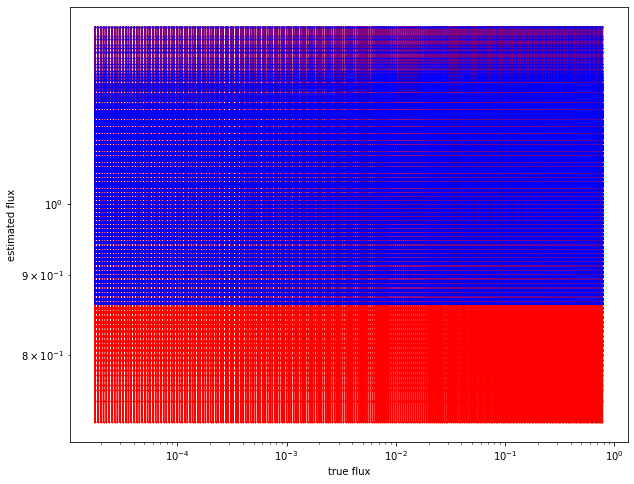

In [73]:
# PLOT true vs estimated flux for all and only detected signals here - log-log
fig,ax=plt.subplots(figsize=(10,8))
plt.plot(true_flux, est_flux, marker='.', markersize=2, color='red')
plt.plot(detected_true_flux, detected_est_flux,marker='.', markersize=2, c='blue', alpha = 0.5)
plt.xlabel('true flux')
plt.ylabel('estimated flux')
plt.xscale('log')
plt.yscale('log')


In [56]:
print(est_flux)

[array([1.00290108]), array([0.93913281]), array([1.0086982]), array([0.90435011]), array([0.91594434]), array([1.13043764]), array([0.97971262]), array([0.99130685]), array([0.96232127]), array([0.99710397]), array([0.95652415]), array([0.9739155]), array([1.01449531]), array([1.1536261]), array([0.97971262]), array([0.94492992]), array([0.89855299]), array([0.98550973]), array([0.91594434]), array([0.99130685]), array([1.02029243]), array([1.0434809]), array([0.84058183]), array([1.0086982]), array([0.92753857]), array([1.00290108]), array([1.0434809]), array([0.96811839]), array([0.9739155]), array([0.88695876]), array([0.87536453]), array([0.99130685]), array([1.0434809]), array([1.01449531]), array([0.90435011]), array([0.88695876]), array([0.88695876]), array([1.11304629]), array([1.10724917]), array([0.92753857]), array([0.89275588]), array([1.09565494]), array([0.98550973]), array([1.03188666]), array([0.92753857]), array([0.94492992]), array([1.04927801]), array([0.95072704]),

Lol this isn't right. It's probably part  of why my plot looks so row-like and discretized :(

Is there a simple code way to put this all in one array like they should have been????


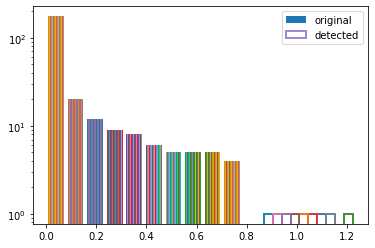

In [74]:


plt.hist(true_flux[::100], lw=2, label='original')
plt.hist(detected_est_flux[::100], lw=2, label='detected', alpha=0.8, histtype='step')
plt.yscale('log')
plt.legend()

Ignore that ^. This got all messed up...

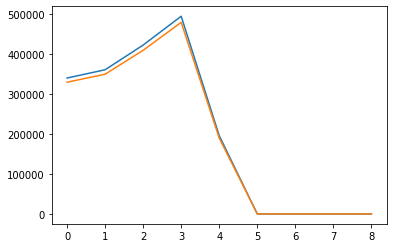

In [66]:
hist,edge=np.histogram(np.log10(true_flux),bins=np.linspace(-3,3,10))
hist2,_=np.histogram(np.log10(detected_true_flux),bins=np.linspace(-3,3,10))

plt.plot(hist, label='True')
plt.plot(hist2, label='detected')
plt.show()

There should be fewer detections at lower flux... it should resemble the Eddington-bias in our sample

<hr>

<font color='blue'>

#### Q9. Draw the PGM for the forward model you just simulated.

</font>

in principle it should look something like this (?):

<img src="PGM.jpg">